---
# **Cross-validation: U-Net on comma10k**
---

Length of the dataset: 1000


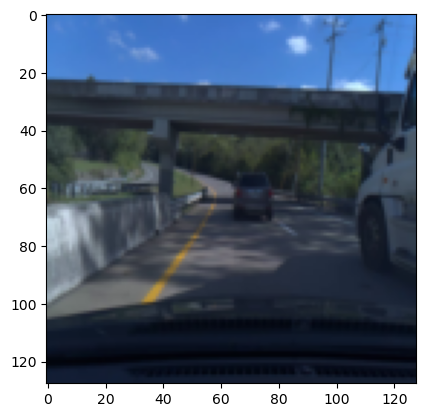

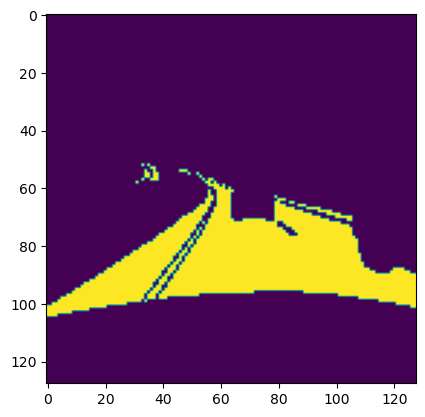

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import seaborn as sns
import os
import numpy as np
from PIL import Image
import random
from torch import manual_seed
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, jaccard_score, precision_score, recall_score, roc_auc_score

to_tensor = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image
    transforms.ToTensor(),
])

def show_tensor(tensor):
    # Convert tensor to NumPy array
    # Transpose from (C, H, W) to (H, W, C) for displaying
    image_np = tensor.permute(1, 2, 0).numpy()
    plt.imshow(image_np)
    plt.show()
    return image_np

ROAD_VALUES = torch.tensor([0.2509804, 0.1254902, 0.1254902]).view(3, 1, 1)
MARKING_VALUES = torch.tensor([1, 0, 0]).view(3, 1, 1)

# remove all other annotations
def binary_tensor(input_tensor):
    # Desired pixel values [0.2509804, 0.1254902, 0.1254902] for each channel

    input_tensor = input_tensor[:3, :, :] if input_tensor.shape[0] > 3 else input_tensor
    road_match = torch.all(torch.abs(input_tensor - ROAD_VALUES) < 0.1, dim=0)
    marking_match = torch.all(torch.abs(input_tensor - MARKING_VALUES) < 0.1, dim=0)
    mask = torch.logical_or(road_match, marking_match).unsqueeze(0)
    return mask.float()

class CommaDataset(Dataset):
    def __init__(self, size):
        image_dir = "/DML/Datasets/comma10k/images/"
        mask_dir = "/DML/Datasets/comma10k/masks/"

        imagelist = os.listdir(image_dir)
        masklist = os.listdir(mask_dir)

        self.imagelist = sorted([os.path.join(image_dir, x) for x in imagelist])[:size]
        self.masklist = sorted([os.path.join(mask_dir, x) for x in masklist])[:size]
        
        #print("Loading masks from dataset...")
        #self.real_mask_list = [torch.load(path) for path in self.masklist]
        #print("Done loading masks.")

    def __len__(self):
        return len(self.masklist)

    def __getitem__(self, index):
        img_path = self.imagelist[index]
        mask_path = self.masklist[index]
        return to_tensor(Image.open(img_path)), binary_tensor(to_tensor(Image.open(mask_path)))
    
    def get_with_name(self, index):
        image, mask = self.__getitem__(index)
        return os.path.split(self.imagelist[index])[-1], image, mask

# Dataset with Max size limit of 1000
commadata = CommaDataset(1000)
print(f"Length of the dataset: {len(commadata)}")

image, mask = commadata[random.randint(0, len(commadata))]
show_tensor(image)
nump = show_tensor(mask)
print(mask)
print(commadata)

**Loading the Data**

In [3]:
test_dataset = commadata
# Assuming `dataset` is your PyTorch Dataset instance
dataset_size = len(test_dataset)

# Set a random seed for reproducibility (optional)
manual_seed(42)

# Create DataLoader for testing
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example output to verify the sizes
print(f"Test dataset size: {len(test_loader.dataset)}")

Test dataset size: 1000


**Network**

In [4]:
# NOTE: Architecture was derived from Andrew Ng's Deep Learning Lecture
# Double Convolution Class
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__()
        self.dconv = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.dconv(x)
    
# Our UNet Model Class 
in_features = 3
out_features = 1

class UNET(nn.Module):
    def __init__(self, in_channels=in_features, out_channels=out_features, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) # Upsampling
            self.ups.append(DoubleConv(feature*2, feature))

        self.left_over = DoubleConv(features[-1], features[-1]*2) # last part which starts the UP phase
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) # output segmentation  map

    def forward(self,x):
        skip_connections = []
        
        # Start Down Phase
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x) 
            x=self.pool(x)
        
        # Pass through (Left-to-Right))
        x=self.left_over(x)
        skip_connections=skip_connections[::-1]

        # Feeding to transposed conv (add skipped connection - 2 steps)
        for idx in range(0,len(self.ups), 2): 
            
            sc=skip_connections[idx//2]
            x=self.ups[idx](x)
            
            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1)  
            x = self.ups[idx+1](concat_skip) 

        return self.final_conv(x)   # No sigmoid here; return logits directly
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
print(f"Network Architecture Used:\n {UNET()}")

Device: cpu
Network Architecture Used:
 UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (dconv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (dconv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256,

**Evaluation Parameters**

In [5]:
# Model Parameters
learning_rate = 1e-4   # Learning Rate
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)   # BCEWithLogitsLoss 
model = UNET(in_channels = 3, out_channels = 1).to(DEVICE) # Choosing the model (Network)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

**Evaluation**

Final Loss: 0.8716 | F1-Score: 0.1135 | IoU: 0.0602 | Accuracy: 0.7492
Precision: 0.1731 | Recall: 0.0844 | ROC-AUC: 0.6298 | TSS: -0.0103


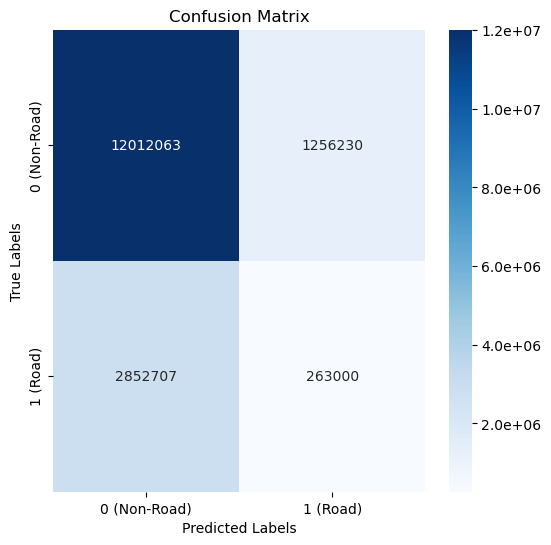

In [6]:
# Loading the Model
model.load_state_dict(torch.load('unet_kitti.pth'))

# EVALUATION PHASE
def evaluate_model(model, data_loader, loss_fn, device):
    
    # Evaluation Mode
    model.eval()
    
    # Initialize 
    all_true_masks = []
    all_pred_masks = []
    all_pred_probs = []  # For ROC-AUC calculation
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        # Loop through the DataLoader
        for test_input, test_mask in data_loader:

            # Set to device
            test_input, test_mask = test_input.to(device), test_mask.to(device)
            
            # Forward pass
            test_outputs = model(test_input.float())
            
            # Compute loss
            loss = loss_fn(test_outputs.float(), test_mask.float())
            total_loss += loss.item()
            num_batches += 1
            
            # Predictions
            predicted_masks = (test_outputs > 0.5).cpu().numpy()  # Set threshold to get binary masks
            predicted_probs = test_outputs.cpu().numpy()  # Keep original probabilities for ROC-AUC
            
            # True Masks
            true_masks = test_mask.cpu().numpy()

            # Appended all results into arrays (for entire DataLoader)
            all_pred_masks.append(predicted_masks)
            all_pred_probs.append(predicted_probs)  
            all_true_masks.append(true_masks)
    
    # Stack all masks to compute evaluation metrics
    all_pred_masks = np.vstack(all_pred_masks)
    all_true_masks = np.vstack(all_true_masks)
    all_pred_probs = np.vstack(all_pred_probs)
    
    # Average/Mean Loss
    avg_loss = total_loss / num_batches

    # Flatten the arrays (to compute evaluation metrics)
    flattened_pred_masks = all_pred_masks.flatten()
    flattened_true_masks = all_true_masks.flatten()
    flattened_pred_probs = all_pred_probs.flatten()  

    # Calculate evaluation metrics
    test_f1 = f1_score(flattened_true_masks, flattened_pred_masks, average='binary')
    test_iou = jaccard_score(flattened_true_masks, flattened_pred_masks, average='binary')
    test_accuracy = accuracy_score(flattened_true_masks, flattened_pred_masks)
    test_precision = precision_score(flattened_true_masks, flattened_pred_masks, average='binary')
    test_recall = recall_score(flattened_true_masks, flattened_pred_masks, average='binary')
    test_roc_auc = roc_auc_score(flattened_true_masks, flattened_pred_probs)

    # Calculate confusion matrix and TSS
    cm = confusion_matrix(flattened_true_masks, flattened_pred_masks)
    test_tss = calculate_tss(cm)  # Compute True Skill Score (TSS)

    return avg_loss, test_f1, test_iou, test_accuracy, test_precision, test_recall, test_roc_auc, test_tss, all_true_masks, all_pred_masks

# Plotting the Confusion Matrix
def plot_confusion_matrix(true_mask, pred_mask):
    cm = confusion_matrix(true_mask.flatten(), pred_mask.flatten())
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0 (Non-Road)", "1 (Road)"], yticklabels=["0 (Non-Road)", "1 (Road)"], cbar_kws={'format': '%.1e'})
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Calculating the TSS (True-Skill-Score) from confusion matrix
def calculate_tss(cm):
    TN, FP, FN, TP = cm.ravel()  # (2x2) confusion matrix (Binary Segmentation)
    TPR = TP / (TP + FN)  # True Positive Rate (Recall)
    FPR = FP / (FP + TN)  # False Positive Rate
    TSS = TPR - FPR
    return TSS

# Plotting the Predicted Masks (alongside True Images and True Masks)
def visualize_predictions(test_input, test_mask, predicted_masks, test_idx):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # True Image
    ax[0].imshow(test_input[test_idx].transpose(1, 2, 0))
    ax[0].set_title("True Image")

    # True Mask
    ax[1].imshow(test_mask[test_idx].transpose(1, 2, 0), cmap='gray')
    ax[1].set_title("True Mask")

    # Predicted Mask
    ax[2].imshow(predicted_masks[test_idx].transpose(1, 2, 0), cmap='gray')
    ax[2].set_title("Predicted Mask")

    plt.tight_layout()
    plt.show()
    
# Evaluating the model on test dataset
(loss, test_f1, test_iou, test_accuracy, test_precision, 
 test_recall, test_roc_auc, test_tss, true_masks, pred_masks) = evaluate_model(model, test_loader, loss_fn, DEVICE)

# Printing the final evalutaion metrics
print(f"Final Loss: {loss:.4f} | F1-Score: {test_f1:.4f} | IoU: {test_iou:.4f} | Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | ROC-AUC: {test_roc_auc:.4f} | TSS: {test_tss:.4f}")

# Plot confusion matrix for all the test images
plot_confusion_matrix(np.vstack(true_masks), np.vstack(pred_masks))

# # Adjust this index to visualize other test samples (test_idx <= len(test_dataloader))
# test_idx_1 = 5  

# # Visualize prediction
# visualize_predictions(test_input, test_mask, pred_masks, test_idx_1)
